In [51]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

In [97]:
def gibbs_sampling(docs, vocab, num_topics, alpha, beta, num_iter = 300):

    num_docs = len(docs)
    
    
    k_d = np.zeros((num_docs, num_topics))  
    i_k = np.zeros((num_topics, vocab))
    top = [] 
    d_i = [] 
    
    for d, doc in enumerate(docs):
        doi_kopics = []
        for word in doc:
            topic = np.random.choice(num_topics)
            doi_kopics.append(topic)
            
            k_d[d, topic] += 1
            i_k[topic, word] += 1
            d_i.append(d)
        top.extend(doi_kopics)
    
    
    for i in range(num_iter):
        for n, word in enumerate([word for doc in docs for word in doc]):
            doc = d_i[n]
            topic = top[n]
            
            
            k_d[doc, topic] -= 1
            i_k[topic, word] -= 1
            
            
            P = (i_k[:, word] + beta) * (k_d[doc, :] + alpha) / ((i_k.sum(axis=1) + beta * vocab) * (k_d[doc, :].sum() + alpha * num_topics))
            P /= P.sum()  
            
            
            new_topic = np.random.choice(num_topics, p=P)
            
            
            k_d[doc, new_topic] += 1
            i_k[new_topic, word] += 1
            top[n] = new_topic
    
    return top, k_d, i_k

In [79]:
def write_topic_words_to_csv(C_t, index_to_word, num_topics, vocab_size, filename="topicwords.csv"):
    topic_word_probabilities = []

    for topic in range(num_topics):
        
        topic_word_counts = C_t[topic]
        topic_word_probs = topic_word_counts / topic_word_counts.sum()
        
        
        top_indices = topic_word_probs.argsort()[-5:][::-1]
        top_words = [index_to_word[i] for i in top_indices]
        top_probs = topic_word_probs[top_indices]
        
        
        topic_word_probabilities.append((top_words, top_probs))
    
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Topic", "Top Words", "Probabilities"])
        for topic, (words, probs) in enumerate(topic_word_probabilities):
            writer.writerow([f"Topic {topic + 1}", words, probs.tolist()])

In [ ]:
def dataset_loader(data_dir):

    docs = []
    word_to_index = {}
    index_to_word = {}
    index_counter = 0

    
    txt_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.txt')], key=lambda x: int(x.split('.')[0]))

    
    for file_name in txt_files:
        file_path = os.path.join(data_dir, file_name)
        with open(file_path, 'r') as f:
            words = f.read().strip().split()
            doc_indices = []
            for word in words:
                if word not in word_to_index:
                    word_to_index[word] = index_counter
                    index_to_word[index_counter] = word
                    index_counter += 1
                doc_indices.append(word_to_index[word])
            docs.append(doc_indices)

    vocab_size = len(word_to_index)
    return docs, vocab_size, word_to_index, index_to_word

In [ ]:
if __name__ == "__main__":
    
    data_dir = "data/20newsgroups" 
    num_topics = 20
    alpha = 5 / num_topics
    beta = 0.01

    
    docs, vocab_size, word_to_index, index_to_word = dataset_loader(data_dir)

    
    top, k_d, i_k = gibbs_sampling(docs, vocab_size, num_topics, alpha, beta)
    
    
    write_topic_words_to_csv(i_k, index_to_word, num_topics, vocab_size)
    print("Top words and their probabilities written")

Top words and their probabilities written


In [81]:
def get_topic_rep(k_d, alpha, num_topics):

    num_docs = len(k_d)
    topic_representations = np.zeros((num_docs, num_topics))
    
    for doc in range(num_docs):
        topic_counts = k_d[doc] 
        denominator = num_topics * alpha + sum(topic_counts)
        
        for k in range(num_topics):
            numerator = topic_counts[k] + alpha
            topic_representations[doc, k] = numerator / denominator
    
    return topic_representations


In [82]:
num_topics = 20
alpha = 5 / num_topics
topic_representations = get_topic_rep(k_d, alpha, num_topics)


# Print results
print("Topic Representations (one row per document) added to topic_representations:")
print(topic_representations)


with open("topic_representations.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        for topic_rep in topic_representations:
            writer.writerow(topic_rep)


Topic Representations (one row per document) added to topic_representations:
[[0.00446429 0.05803571 0.02232143 ... 0.00446429 0.00446429 0.00446429]
 [0.00185185 0.12777778 0.0462963  ... 0.00185185 0.12777778 0.00185185]
 [0.00454545 0.11363636 0.00454545 ... 0.00454545 0.35       0.00454545]
 ...
 [0.05113636 0.00568182 0.02840909 ... 0.07386364 0.25568182 0.02840909]
 [0.00555556 0.00555556 0.07222222 ... 0.00555556 0.05       0.00555556]
 [0.00555556 0.00555556 0.05       ... 0.00555556 0.13888889 0.00555556]]


Task2 : Classification using BLR

In [ ]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [84]:
def bayesian_logistic_regression(fi, ti, alpha):
    
    fi = np.hstack([np.ones((fi.shape[0], 1)), fi])
    w = np.zeros(fi.shape[1])
    for iteration in range(100):
        y_pred = sigmoid(fi @ w)
        R = np.diag(y_pred * (1 - y_pred))
        grad = fi.T @ (y_pred - ti) + alpha * w
        H = fi.T @ R @ fi + alpha * np.identity(fi.shape[1])
        w_new = w - np.linalg.inv(H) @ grad
        if np.linalg.norm(w_new - w) / np.linalg.norm(w) < 1e-3:
            break
        w = w_new
    return w


In [85]:
def generate_bag_of_words(folder_path, index_file):

    doc_labels = {}
    labels = []
    with open(index_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row) >= 2:
                doc_labels[int(row[0])] = int(row[1])
                labels.append(int(row[1]))

    documents = {}
    vocab = set()

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            doc_id = int(file_name.split('.')[0])
            if os.path.isfile(file_path) and doc_id in doc_labels:
                with open(file_path, 'r') as f:
                    words = f.read().strip().split()
                    documents[doc_id] = words
                    vocab.update(words)
        except ValueError:
            continue

    vocab = sorted(vocab)
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    num_docs = len(doc_labels)
    num_words = len(vocab)
    bow_representation = np.zeros((num_docs, num_words), dtype=int)

    for doc_id, words in documents.items():
        doc_idx = list(doc_labels.keys()).index(doc_id)
        word_count = {}
        for word in words:
            if word in word_to_index:
                word_count[word] = word_count.get(word, 0) + 1
        for word, count in word_count.items():
            word_idx = word_to_index[word]
            bow_representation[doc_idx, word_idx] = count

    return bow_representation, np.array(labels), vocab

In [86]:
def load_topic_representations(file_path):

    return np.loadtxt(file_path, delimiter=',', skiprows=1, usecols=range(1, 20))

In [102]:
def generate_lc(representation, labels):
    alpha = 0.1
    num_trials = 30
    training_sizes, mean_errors, std_errors = [], [], []
    for size in (np.linspace(0.1, 0.9, 5) * len(labels)).astype(int):
        errors = []
        for _ in range(num_trials):
            indices = np.random.permutation(len(labels))
            train_indices = indices[:size]
            test_indices = indices[size:]
            phi_train, t_train = representation[train_indices], labels[train_indices]
            phi_test, t_test = representation[test_indices], labels[test_indices]
            w = bayesian_logistic_regression(phi_train, t_train, alpha)
            phi_test = np.hstack([np.ones((phi_test.shape[0], 1)), phi_test])
            predictions = (1 / (1 + np.exp(-phi_test @ w))) >= 0.5
            errors.append(np.mean(predictions != t_test))
        training_sizes.append(size/100)
        mean_errors.append(np.mean(errors))
        std_errors.append(np.std(errors))
    return training_sizes, mean_errors, std_errors

/var/folders/nw/xhdd54cd0390h_t_5hl9v19h0000gn/T/ipykernel_29261/482388560.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  if np.linalg.norm(w_new - w) / np.linalg.norm(w) < 1e-3:


time for bow:  11.292974948883057
time for topic:  0.12464308738708496


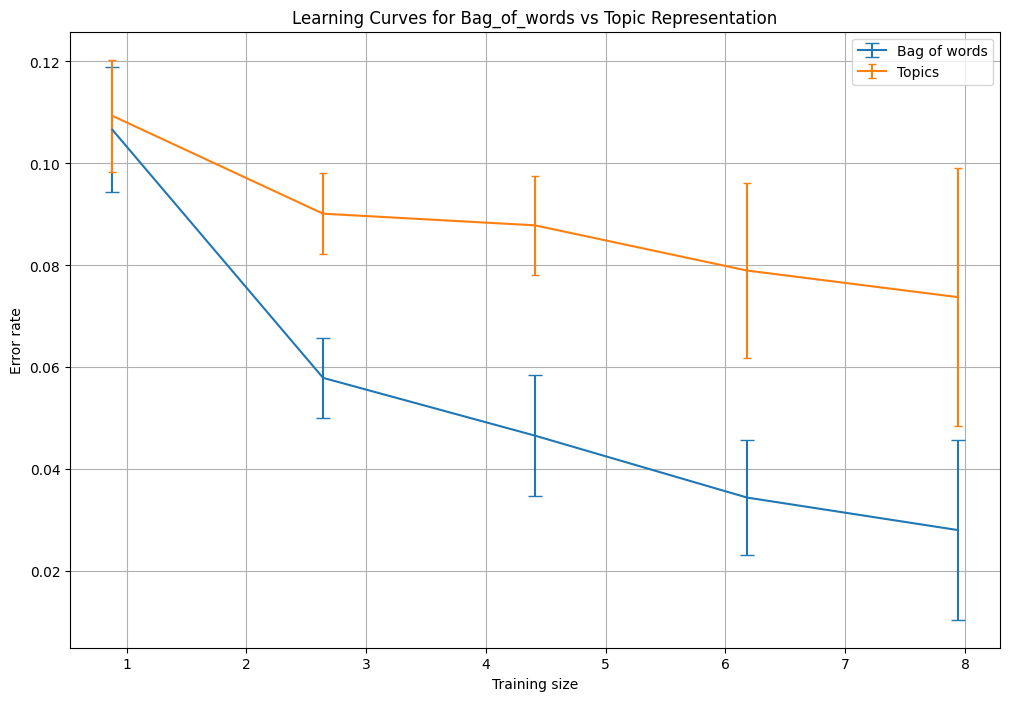

BoW Learning Curve:
Sizes: [np.float64(0.88), np.float64(2.64), np.float64(4.41), np.float64(6.18), np.float64(7.94)]
Mean Errors: [np.float64(0.10662473794549271), np.float64(0.057942918686052766), np.float64(0.046606334841628974), np.float64(0.03446540880503145), np.float64(0.028089887640449437)]
Std Errors: [np.float64(0.01220701989917516), np.float64(0.007800675912646989), np.float64(0.011836997983851238), np.float64(0.011267519837262234), np.float64(0.017587051508425308)]

Document-Topic Learning Curve:
Sizes: [np.float64(0.88), np.float64(2.64), np.float64(4.41), np.float64(6.18), np.float64(7.94)]
Mean Errors: [np.float64(0.10935010482180298), np.float64(0.09014539579967691), np.float64(0.0878582202111614), np.float64(0.07899371069182393), np.float64(0.07378277153558052)]
Std Errors: [np.float64(0.010994283159076976), np.float64(0.007907746850093968), np.float64(0.009706266157953676), np.float64(0.017097666754763468), np.float64(0.025238555189260593)]


In [105]:
import time 
if __name__ == "__main__":
    folder_path = "data/20newsgroups"
    index_file = "data/20newsgroups/index.csv"
    topic_representation_file = "topic_representations.csv"

    bow_representation, labels, vocab = generate_bag_of_words(folder_path, index_file)

    if len(labels) > bow_representation.shape[0]:
        labels = labels[:bow_representation.shape[0]]

    topic_representation = load_topic_representations(topic_representation_file)
    
    start_time = time.time()
    bow_training_sizes, bow_mean_errors, bow_std_errors = generate_lc(bow_representation, labels)
    end_time  = time.time()
    print("time for bow: ", end_time - start_time)

    start_time = time.time()
    topic_training_sizes, topic_mean_errors, topic_std_errors = generate_lc(topic_representation, labels)
    end_time  = time.time()
    print("time for topic: ", end_time - start_time)

    plt.figure(figsize=(12, 8))
    plt.errorbar(bow_training_sizes, bow_mean_errors, yerr=bow_std_errors, label='Bag of words', capsize=5)
    plt.errorbar(topic_training_sizes, topic_mean_errors, yerr=topic_std_errors, label='Topics', capsize=3)
    plt.xlabel('Training size')
    plt.ylabel('Error rate')
    plt.title('Learning Curves for Bag_of_words vs Topic Representation')
    plt.legend()
    plt.grid(True)
    plt.show()    

    print("BoW Learning Curve:")
    print(f"Sizes: {bow_training_sizes}")
    print(f"Mean Errors: {bow_mean_errors}")
    print(f"Std Errors: {bow_std_errors}")

    print("\nDocument-Topic Learning Curve:")
    print(f"Sizes: {topic_training_sizes}")
    print(f"Mean Errors: {topic_mean_errors}")
    print(f"Std Errors: {topic_std_errors}")

Extra credit

Running Gibbs sampler with 50 iterations...


/var/folders/nw/xhdd54cd0390h_t_5hl9v19h0000gn/T/ipykernel_29261/482388560.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  if np.linalg.norm(w_new - w) / np.linalg.norm(w) < 1e-3:


Running Gibbs sampler with 100 iterations...
Running Gibbs sampler with 200 iterations...
Running Gibbs sampler with 300 iterations...
Running Gibbs sampler with 500 iterations...


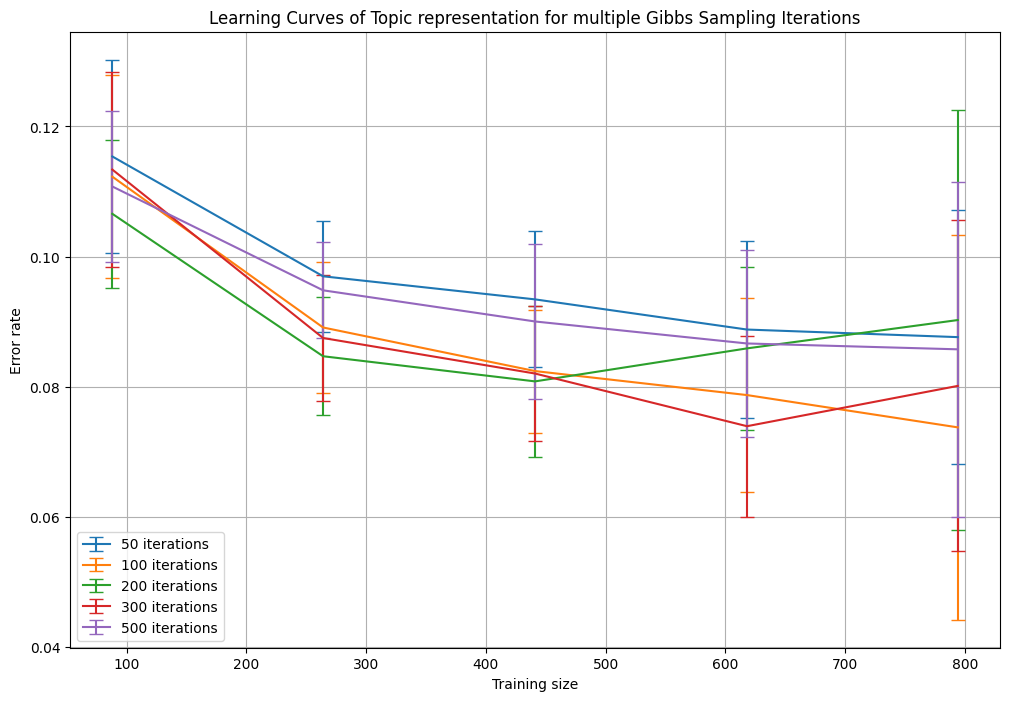


Iteration count: 50
Sizes: [np.int64(88), np.int64(264), np.int64(441), np.int64(618), np.int64(794)]
Mean Errors: [np.float64(0.11538784067085955), np.float64(0.09698438341410878), np.float64(0.09343891402714935), np.float64(0.08880503144654091), np.float64(0.08764044943820225)]
Std Errors: [np.float64(0.014854606845121), np.float64(0.008543209897402792), np.float64(0.010452227507787942), np.float64(0.01363141351863554), np.float64(0.01954754809093616)]

Iteration count: 100
Sizes: [np.int64(88), np.int64(264), np.int64(441), np.int64(618), np.int64(794)]
Mean Errors: [np.float64(0.11228511530398326), np.float64(0.08912224017232094), np.float64(0.08242835595776773), np.float64(0.07874213836477989), np.float64(0.07378277153558052)]
Std Errors: [np.float64(0.015639806425995495), np.float64(0.010080942286750633), np.float64(0.009449745945120594), np.float64(0.014927802464550237), np.float64(0.02954056784525992)]

Iteration count: 200
Sizes: [np.int64(88), np.int64(264), np.int64(441), n

In [ ]:

def extra_credits(docs, vocab_size, num_topics, alpha, beta, iteration_counts, labels, topic_representation_file):
 
    all_training_sizes, all_mean_errors, all_std_errors = [], [], []

    np.random.seed(42)

    for num_iter in iteration_counts:
        print(f"Running Gibbs sampler with {num_iter} iterations...")
        
       
        top, k_d, i_k = gibbs_sampling(docs, vocab_size, num_topics, alpha, beta, num_iter)
        
  
        topic_representation = get_topic_rep(k_d, alpha, num_topics)
        

        topic_training_sizes, topic_mean_errors, topic_std_errors = generate_lc(topic_representation, labels)
        
        all_training_sizes.append(topic_training_sizes)
        all_mean_errors.append(topic_mean_errors)
        all_std_errors.append(topic_std_errors)
    
    return all_training_sizes, all_mean_errors, all_std_errors

if __name__ == "__main__":
    data_dir = "data/20newsgroups" 
    num_topics = 20
    alpha = 5 / num_topics
    beta = 0.01
    

    docs, vocab_size, word_to_index, index_to_word = dataset_loader(data_dir)
    folder_path = "data/20newsgroups"
    index_file = "data/20newsgroups/index.csv"
    bow_representation, labels, vocab = generate_bag_of_words(folder_path, index_file)


    iteration_counts = [50, 100, 200, 300, 500]
    topic_representation_file = "topic_representations.csv"
    

    all_training_sizes, all_mean_errors, all_std_errors = extra_credits(docs, vocab_size, num_topics, alpha, beta, iteration_counts, labels, topic_representation_file)
    

    plt.figure(figsize=(12, 8))
    for i, num_iter in enumerate(iteration_counts):
        plt.errorbar(all_training_sizes[i], all_mean_errors[i], yerr=all_std_errors[i], label=f'{num_iter} iterations', capsize=5)
    
    plt.xlabel('Training size')
    plt.ylabel('Error rate')
    plt.title('Learning Curves of Topic representation for multiple Gibbs Sampling Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    for i, num_iter in enumerate(iteration_counts):
        print(f"\nIteration count: {num_iter}")
        print(f"Sizes: {all_training_sizes[i]}")
        print(f"Mean Errors: {all_mean_errors[i]}")
        print(f"Std Errors: {all_std_errors[i]}")
